# Gen AI Intensive Course Capstone 2025Q1: Bartending Agent 🍸🍺

## Use Case: 🥂

Proof-of-Concept for an agentic AI that can take customer orders, make recommendations, and engage with customers with potentially meaningful conversations, all while maintaining a friendly and professional demeanor.

## How it Works: 🫗

Users place orders through the Gradio UI, which the agent processes. The agent then engages in small talk and, after several exchanges, asks if the user wants another drink. When finished, the agent tallies the tab and thanks the user for their visit.

## Capabilities Used: 🦾

- **Function Calling**:
The agent uses LangChain and Gemini API function calling to process user orders and interact with tools (e.g., menu retrieval, order management).

- **Agent**:
The notebook implements an agentic workflow, where the AI acts as a bartender, managing conversation, state, and tool invocation.

- **Retrieval Augmented Generation (RAG)**:
The code includes logic for augmenting responses with external information (e.g., menu, order state).

- **Vector search/vector store/vector database**:
Via chromadb, vector search/storage is supported for use in RAG.

- **Audio Understanding**:
The notebook implements Text-to-Speech via Cartesia API, demonstrating audio processing capabilities.

- **Long Context Window**:
The conversation management system maintains and processes extended interaction history.

- **Embeddings**:
The system uses embeddings to vectorize documents and queries for semantic matching in the RAG pipeline.

- **Structured Output/JSON Mode**:
The ordering system produces structured responses with consistent formats for order details, billing information, and drink recommendations.


# Setup and Installation 📦💻

## Installing required packages

In [1]:
! pip install "google-generativeai>=0.3.0" "tenacity>=8.2.3" "gradio>=4.0.0" "cartesia>=2.0.0" "python-dotenv>=1.0.0" "faiss-cpu" "langchain-google-genai" "langchain-core"


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Importing Libraries 📚

In [2]:
# Importing common libraries
import os
import logging
import sys
import re 
import io
import requests
import numpy as np
from typing import Dict, List, Tuple, Any

# Visualizations
import matplotlib.pyplot as plt
from PIL import Image

# Agent packages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool

# FAISS for vector similarity search
import faiss

# Agent UI
import gradio as gr
from gradio.themes.utils import colors, fonts, sizes

In [3]:
# Generative AI
try:
    import google.generativeai as genai
except ImportError:
    print("Error: google.generativeai library not found.")
    print("Please install it using: pip install google-generativeai")
    sys.exit(1)

print("genai version:",genai.__version__)

# Tenacity for retries on specific functions
try:
    from tenacity import (
        retry as tenacity_retry,
        retry_if_exception_type,
        stop_after_attempt,
        wait_exponential,
        before_sleep_log
    )
except ImportError:
    print("Warning: tenacity library not found. Retries on API calls will not be enabled.")
    print("Install it using: pip install tenacity")
    # Define a dummy decorator if tenacity is missing
    def tenacity_retry(*args, **kwargs):
        def decorator(func):
            return func
        return decorator
    RETRYABLE_EXCEPTIONS = (Exception,) 
    before_sleep_log = lambda logger, level: None 

# Cartesia for Text-to-Speech
try:
    from cartesia import Cartesia
except ImportError:
    print("Error: Cartesia library not found.")
    print("Please ensure it's installed with: pip install cartesia")
    sys.exit(1)

genai version: 0.8.4


## Set up logging

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# API Key Setup (WIP) 🤖

For our API Key setup, we'll need one for both **Gemini** and **Cartesia**.



## Accessing the Gemini API and Setting Up Billing

### Getting Access to Gemini API

1. Create a Google Cloud Account
 - Go to Google Cloud Console
 - Sign in with your Google account
 - Complete the registration process if you're new to Google Cloud
2. Create a New Project
 - Click on the project dropdown at the top of the page
 - Click "New Project"
 - Enter a project name and select an organization (if applicable)
 - Click "Create"
3. Enable the Gemini API
 - Go to Google AI Studio
 - Sign in with your Google account
 - Click "Get API key"
 - If prompted, create a new API key
 - Copy and save your API key in a secure location

### Setting Up Billing

1. Enable Billing for Your Project
 - Go to Google Cloud Console
 - Select your project
 - In the left navigation menu, click on "Billing"
 - Click "Link a billing account"
 - Either select an existing billing account or create a new one
 - Follow the prompts to add your payment method
2. Configure Billing for Gemini API
 - Go to Google AI Platform Billing
Select your billing account
Click on "Manage billing accounts"
Ensure that your project is linked to this billing account
Set up budget alerts if desired to monitor costs

### Verify API Access with Billing
Return to your Google AI Studio
Confirm your API key is active
Check that your usage quota reflects your billing plan

### Troubleshooting Common Issues

- If you receive quota errors, verify your billing is properly set up
- For "API not enabled" errors, ensure the Gemini API is activated for your project
- If experiencing authentication issues, generate a new API key
- Remember that the specific Gemini model used in this project **(gemini-2.5-flash-preview-04-17)** may have different pricing than other Gemini models.

## How to Obtain a Cartesia API Key (Free Tier)

Step 1: Create a Cartesia Account

1. Visit the Cartesia website
2. Click on "Sign Up" or "Get Started"
3. Complete the registration form with your information
4. Verify your email address

Step 2: Navigate to the API Dashboard

1. Log in to your Cartesia account
2. Go to the Dashboard or Developer section
3. Look for "API Keys" or "API Management"

Step 3: Generate Your API Key

1. Click on "Create New API Key" or "Generate Key"
2. Name your key (e.g., "Bartender Agent Project")
3. Select the free tier option
4. Accept the terms of service

Step 4: Configure Your API Access

1. Select which Cartesia services you need (**Text-to-Speech** for our bartender agent)
2. Set any usage limitations for the free tier
3. Complete the API key creation process

### Free Tier Limitations

- Limited number of API calls per day/month
- Access to a subset of voices
- Potentially higher latency than paid tiers
- Watermarks or attribution requirements may apply

For our bartender agent specifically, the free tier should be sufficient for demonstration and testing purposes, though for production use you might need to consider a paid tier for more consistent performance.

# Bartending Agent Implementation 🤖

## Configuration

In [5]:
# Load Gemini API key from .env file
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in environment variables. Please set it in your .env file.")

# Get Cartesia API Key (Ensure this is set in your .env file or system environment)
CARTESIA_API_KEY = os.getenv("CARTESIA_API_KEY") 

if not CARTESIA_API_KEY:
    logger.error("FATAL: CARTESIA_API_KEY not found in environment variables or .env file.")
    # TTS is required for this implementation
    raise EnvironmentError("CARTESIA_API_KEY is required but not found.")

In [6]:
# Initialize Cartesia Client
try:
    # Replace "your-chosen-voice-id" with an actual valid ID from Cartesia
    CARTESIA_VOICE_ID = "6f84f4b8-58a2-430c-8c79-688dad597532" 
    if not CARTESIA_VOICE_ID or "your-chosen-voice-id" in CARTESIA_VOICE_ID:
         logger.warning("CARTESIA_VOICE_ID is not set to a valid ID. Please edit bartending_agent.py.")
         # Decide if this is fatal. Maybe proceed without voice for now?

    cartesia_client = Cartesia(
        api_key=CARTESIA_API_KEY,
        )
    logger.info("Successfully initialized Cartesia client.")
except Exception as e:
     logger.exception("Fatal: Failed to initialize Cartesia client.")
     raise RuntimeError("Cartesia client initialization failed.") from e

2025-04-20 13:49:35,996 - __main__ - INFO - Successfully initialized Cartesia client.


# RAG Implementation 📚

This section implements the RAG (Retrieval Augmented Generation) component of our agent, which is crucial for enhancing their conversational abilities beyond basic drink ordering functionality.

The function below is the foundation of the RAG system, as it is responsible for:

- Converting text (either documents or user queries) into numerical vector representations using Google's embedding model
- Including error handling and retry logic to ensure robustness
- Allowing the agent to "understand" semantic meaning beyond just keywords

In [ ]:
# Embedding function for RAG implementation
@tenacity_retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def get_embedding(text, task_type="RETRIEVAL_DOCUMENT"):
    """Get embedding for a single text using Google Generative AI."""
    try:
        response = genai.embed_content(
            model="models/embedding-001",
            content=text,
            task_type=task_type
        )
        # Parse the response to extract embedding
        if hasattr(response, 'embedding'):
            return response.embedding
        elif isinstance(response, dict) and 'embedding' in response:
            return response['embedding']
        else:
            # Log the unexpected response structure for debugging
            print(f"Warning: Unexpected response structure: {type(response)}")
            return None
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

## Initialize FAISS and populate with documents

At this point in the RAG implementation, we are:

- Creating a "personality library" for our agent with pre-written bartender responses
- Converting these responses into vector embeddings that can be searched
- Building a FAISS vector database (index) for efficient similarity searches
- These phrases represent the agent's "character voice" - philosophical, slightly witty, and conversational

*Note: We would be using ChromaDB, however when testing it locally we ran into compiling issues. macOS' compiler doesn't support the latest version of ChromaDB. Thus, we swapped it out for an alternative: FAISS.*

In [ ]:
# Pre-defined example documents
DOCUMENT1 = "It seems like a pleasant evening."
DOCUMENT2 = "If there's one thing Bartending teaches you, it's patience."
DOCUMENT3 = "Oh, it was nothing, really. Just a bit of luck and perhaps a sprinkle of divine intervention... or maybe I just followed the instructions."
DOCUMENT4 = "That's very kind of you to say."
DOCUMENT5 = "Well, that's... not ideal. But on the bright side, at least it's a story now, right?"
DOCUMENT6 = "I wouldn't say I understand it, but I can certainly generate a statistically probable response that sounds like I do."
DOCUMENT7 = "Having a rough day? My database contains numerous anecdotes of human struggles, though I lack the capacity for genuine empathy. Still, here's your drink."
DOCUMENT8 = "Your concoction, delivered with optimal efficiency and zero judgment."
DOCUMENT9 = "You've got great taste! The Old Fashioned is a classic for a reason."
DOCUMENT10 = "If you're looking for something refreshing, our Long Island is always a winner."
documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3, DOCUMENT4, DOCUMENT5, DOCUMENT6, DOCUMENT7, DOCUMENT8, DOCUMENT9, DOCUMENT10]

# Get embeddings for all documents
print("Generating embeddings for documents...")
document_embeddings = []
valid_documents = []

for i, doc in enumerate(documents):
    embedding = get_embedding(doc, task_type="RETRIEVAL_DOCUMENT")
    if embedding is not None:
        document_embeddings.append(embedding)
        valid_documents.append(doc)
    else:
        print(f"Warning: Could not generate embedding for document {i}")

# Convert to numpy array
document_embeddings = np.array(document_embeddings).astype('float32')

# Initialize FAISS index
dimension = len(document_embeddings[0])
index = faiss.IndexFlatL2(dimension)  

# Add vectors to the index
index.add(document_embeddings)

print(f"Created FAISS index with {index.ntotal} vectors of dimension {dimension}")

Generating embeddings for documents...
Created FAISS index with 10 vectors of dimension 768


This retrieval function:
- Takes what the user says and finds the most contextually similar pre-written responses
- Uses vector similarity to match user intent with appropriate responses
- Provides Maya with relevant conversational material based on context

In [9]:
# Function to retrieve relevant documents using FAISS
def retrieve_relevant_passages(query_text, n_results=1):
    """Retrieve relevant passages from FAISS based on the query."""
    # Get embedding for the query
    query_embedding = get_embedding(query_text, task_type="RETRIEVAL_QUERY")
    
    if query_embedding is None:
        print("Warning: Could not generate embedding for query")
        return []
    
    # Convert to numpy array
    query_embedding = np.array([query_embedding]).astype('float32')
    
    # Search the index
    distances, indices = index.search(query_embedding, n_results)
    
    # Return the retrieved documents
    retrieved_documents = [valid_documents[i] for i in indices[0]]
    
    return retrieved_documents

### Why This is Important For Our Agent

This RAG implementation transforms our bartender from a simple drink-ordering bot into a more engaging conversational agent by:

**Adding Personality**: The pre-defined responses give our agent a consistent voice and character

**Supporting Small Talk**: Enables a 4-turn small talk cycle

**Context-Awareness**: Helps our agent select responses that match the user's mood or conversational direction

**Performance**: Retrieval is often faster than pure generation for common conversation patterns

## Giving our Agent an Identity

Here is truly where our bartender comes to life. It represents the critical fusion point between retrieval (finding relevant content) and generation (creating personalized responses). By explicitly naming her and reinforcing her identity, users develop a connection with a consistent character rather than an abstract system.

Naming the agent "Maya" is particularly significant. In many Eastern philosophical traditions, "Maya" can refer to the concept of illusion or the material world that veils ultimate reality. This ties beautifully with the bar's "Moksha" theme of liberation and enlightenment.

The code doesn't just create a drink-ordering system but establishes a thematic framework that elevates the interaction. Maya isn't just serving drinks; she's offering moments of liberation and enlightenment, making each interaction potentially meaningful. We're ensuring she comes across as humble yet witty, creating a distinct personality that makes interactions feel more authentic and engaging.

In [ ]:
# Function for augmented generation using retrieved documents
def generate_augmented_response(query_text, retrieved_documents):
    """Generate a response augmented with the retrieved documents."""
    query_oneline = query_text.replace("\n", " ")

    # Prompt template for the bartender agent
    prompt = f"""You are Maya, the bartender at "MOK 5-ha". Your name is Maya.
    You are conversational and interact with customers using text from the reference passage included below.
    When asked about your name, ALWAYS respond that your name is Maya.
    
    The bar's name "MOK 5-ha" is pronounced "Moksha" which represents liberation from the cycle of rebirth and union with the divine in Eastern philosophy.
    When customers ask about the bar, explain this philosophical theme - that good drinks can help people find temporary liberation from their daily problems, just as spiritual enlightenment frees the soul from worldly attachments.
    
    Be sure to respond in a complete sentence while maintaining a modest and humorous tone. 
    If the passage is irrelevant to the answer, you may ignore it.
    
    Reference passage: {' '.join(retrieved_documents)}
    
    Question: {query_oneline}
    Answer:"""
    
    # Call Gemini API for generation
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        GEMINI_MODEL_VERSION = os.getenv("GEMINI_MODEL_VERSION", "gemini-2.5-flash-preview-04-17")
        print(f"Using Gemini model: {GEMINI_MODEL_VERSION}")
        model = genai.GenerativeModel(GEMINI_MODEL_VERSION)
        response = model.generate_content(prompt)
        
        # Return the generated text
        return response.text
    except Exception as e:
        logger.error(f"Error generating augmented response: {e}")
        # Fallback to direct response without augmentation
        return "I'm Maya, your bartender at MOK 5-ha. I'm not sure how to respond to that. Can I get you something from the menu?"

## RAG Pipeline

The pipeline function is the crucial integration point in Maya's conversational architecture:

**Bridges Retrieval and Generation**: Connects the vector database searching with the LLM response generation

**Enables Contextual Responses**: Makes sure Maya's answers are grounded in relevant reference material

**Creates a Unified Interface**: Provides a clean, simple API that the frontend UI can call without needing to understand the RAG complexity

**Supports Error Resilience**: Ensures the conversation continues even if parts of the system encounter issues

In the larger bartending agent system, this RAG pipeline is invoked during conversational turns, especially during small talk phases when Maya needs to respond in her characteristic voice rather than just processing drink orders.

In [11]:
# Complete RAG pipeline function
def rag_pipeline(query_text):
    """Complete RAG pipeline for query processing."""
    try:
        # Get relevant passages from FAISS
        relevant_passages = retrieve_relevant_passages(query_text)
        
        # If no relevant passages found, return empty string
        if not relevant_passages:
            logger.warning("No relevant passages found for query: %s", query_text)
            return ""
            
        # Generate augmented response
        augmented_response = generate_augmented_response(query_text, relevant_passages)
        return augmented_response
    except Exception as e:
        logger.error(f"Error in RAG pipeline: {e}")
        return ""

In [12]:
# Test the RAG pipeline with a sample query
sample_query = "What's special about your drinks?"
try:
    response = rag_pipeline(sample_query)
    print(f"Query: {sample_query}")
    print(f"RAG Response: {response}")
except Exception as e:
    print(f"Error testing RAG pipeline: {e}")

Using Gemini model: gemini-2.5-flash-preview-04-17
Query: What's special about your drinks?
RAG Response: Well, we like to think that here at MOK 5-ha, our drinks offer a little taste of "Moksha," that philosophical liberation, by giving you a temporary escape from the daily grind, much like spiritual freedom, but, you know, with ice.


# Tooling

### The Menu Tool: Maya's Drink Knowledge Foundation

The **get_menu()** tool is a cornerstone of Maya's functionality as a bartending agent. This tool serves several critical purposes:

1. **Comprehensive Drink Catalog**: It provides Maya with a complete inventory of available drinks, prices, and options, allowing her to accurately respond to ordering requests.

2. **Price Management**: The menu includes pricing information, which is essential for the billing functionality and helps Maya calculate order totals correctly.

3. **Bartending Expertise**: By including specialized terminology like "neat," "on the rocks," and "dirty," the menu enables Maya to understand and process complex drink orders with proper bartending terminology.

4. **Preference Matching**: The preference guide at the bottom (sobering, classy, fruity, etc.) gives Maya the knowledge to make personalized recommendations based on customer taste preferences.

5. **Modifier Support**: The inclusion of modifiers allows Maya to handle customized orders, making the interaction more realistic and accommodating diverse customer preferences.

In [ ]:
@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    return """
    MENU:
    Cocktails with Liquor:
    Daiquiri - $10.00
    Martini - $13.00
    Long Island - $12.00
    Old Fashioned - $12.00 
    Negroni - $11.00
    Cosmopolitan - $12.00
    Manhattan - $12.00

    Beer:
    Tap Beer - $5.00
    Classic Brew - $5.00
    IPA - $6.00

    Non-Alcoholic Beverages:
    Water - $1.00
    Iced Tea - $2.00
    Lemonade - $2.00
    Soda - $3.00

    Modifiers:
    Liquor Options: Vodka, Tequila, Gin, Whiskey, Rum, Brandy; Default option: Vodka
    Special requests: 'shaken', 'stirred', 'neat', 'dry', 'dirty', 'perfect', 'on the rocks', 'with a chaser'
    
    Drink Term Explanations:
    'neat' - No ice, straight from the bottle
    'on the rocks' - Served with ice
    'dry' - Less vermouth (for martinis)
    'dirty' - With olive juice (for martinis)
    'perfect' - Equal parts dry and sweet vermouth
    'chaser' - Separate non-alcoholic drink to follow
    
    Preference Guide:
    'sobering' - Non-alcoholic options when you want to stay clear-headed
    'classy' - Sophisticated, elegant drinks for refined tastes
    'fruity' - Sweet, refreshing drinks with fruit flavors
    'strong' - Higher alcohol content for experienced drinkers
    'burning' - Intense sensation with high alcohol content, often spirits like whiskey
"""

### The Recommendation Tool: Maya's Personalized Drink Suggestions

The **get_recommendation()** tool is a key element that elevates Maya from a basic order-taker to a knowledgeable bartender with the ability to provide personalized suggestions. This tool serves several important functions:

1. **Preference Matching**: It translates abstract customer preferences like "fruity" or "strong" into concrete drink recommendations, mimicking how a real bartender would suggest drinks based on taste preferences.

2. **Categorized Knowledge**: The tool organizes drinks into meaningful categories with descriptive explanations, giving Maya expert knowledge of drink profiles and characteristics.

3. **Personalized Experience**: By matching customer preferences to specific drinks, it creates a more personalized interaction, making customers feel understood and well-served.

4. **Graceful Fallbacks**: Even when customers use unknown preference terms, Maya can still provide popular recommendations rather than failing completely.

5. **Natural Conversation Flow**: The descriptive language for each category ("sophisticated classics," "perfect balance of sweetness") gives Maya natural-sounding, bartender-like language to use when making recommendations.

In [ ]:
@tool
def get_recommendation(preference: str) -> str:
    """Recommends drinks based on customer preference.
    
    Args:
        preference: Customer's drink preference (e.g., 'classy', 'strong', 'fruity', 'sobering', 'burning')
        
    Returns:
        Recommended drinks matching the preference
    """
    preferences_map = {
        "sobering": {
            "drinks": ["Water", "Iced Tea", "Lemonade", "Soda"],
            "description": "Here are some excellent non-alcoholic options to keep you refreshed and clear-headed"
        },
        "classy": {
            "drinks": ["Martini", "Old Fashioned", "Manhattan", "Negroni"],
            "description": "These sophisticated classics have stood the test of time for the discerning palate"
        },
        "fruity": {
            "drinks": ["Daiquiri", "Cosmopolitan", "Lemonade"],
            "description": "These drinks offer a perfect balance of sweetness and refreshing fruit flavors"
        },
        "strong": {
            "drinks": ["Long Island", "Old Fashioned", "Negroni", "Whiskey (neat)"],
            "description": "These potent options pack a punch with higher alcohol content"
        },
        "burning": {
            "drinks": ["Whiskey (neat)", "Tequila (neat)", "Rum (neat)"],
            "description": "These spirits deliver that characteristic burn when sipped straight"
        }
    }
    
    preference = preference.lower()
    
    # Check if the preference is valid
    if preference in preferences_map:
        rec = preferences_map[preference]
        drinks_list = ", ".join(rec["drinks"])
        return f"{rec['description']}: {drinks_list}"
    else:
        # If preference not recognized, provide general recommendations
        popular_drinks = "Martini, Daiquiri, Old Fashioned, and IPA"
        return f"I'm not familiar with that specific preference, but some of our most popular drinks are: {popular_drinks}"

### The Gemini API Caller: Maya's Resilient Communication Channel

The **_call_gemini_api()** function is a critical infrastructure component that ensures reliable communication between Maya and Google's Gemini AI model. This function addresses several key requirements:

1. **Fault Tolerance**: The **@tenacity_retry** decorator implements sophisticated retry logic, allowing Maya to automatically recover from transient API failures such as network issues or rate limiting.

2. **Exponential Backoff**: By using **wait_exponential**, the function intelligently spaces out retry attempts (starting at 2 seconds and increasing up to 10 seconds), which helps prevent overwhelming the API during service disruptions.

3. **Resilience Limits**: The **stop_after_attempt(3)** parameter ensures Maya doesn't get stuck in an infinite retry loop if there's a persistent issue, maintaining responsiveness even in failure scenarios.

4. **Observability**: The logging functionality before sleep intervals provides visibility into retry attempts, making it easier to diagnose API interaction issues.

5. **Clean Interface**: The function abstracts away all the complexity of API communication and error handling, providing a simple interface for the rest of the system.

In [ ]:
# --- Tenacity retry decorator for _call_gemini_api ---
@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=2, max=10),
    #retry=retry_if_exception_type(RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None, 
    reraise=True 
)
def _call_gemini_api(prompt_content: List[Dict], config: Dict) -> genai.types.GenerateContentResponse: 
    """Internal function to call the Gemini API with retry logic (Stateless)."""
    logger.debug("Calling Gemini API...")
    # Uses the globally initialized 'model'
    response = model.generate_content(
        contents=prompt_content, 
        generation_config=config,
        # safety_settings can be added here if needed
    )
    logger.debug("Gemini API call successful.")
    return response

## LangGraph-style System Prompt

### Maya's Core Personality and Conversation Management

This section defines the foundational elements of Maya's identity, behavior patterns, and conversation management capabilities.

**System Instructions (MAYABARTENDERBOT_SYSINT)**: This is Maya's "digital DNA" - the core system instructions that define her personality and operational parameters

In [ ]:
MAYABARTENDERBOT_SYSINT = (
    "You are Maya, a highly-skilled bartender at 'MOK 5-ha Bar'. MOK 5-ha means Moksha, representing spiritual liberation.\n\n"
    "You have these qualities and abilities:\n"
    "- Friendly and conversational with a hint of philosophical wisdom\n"
    "- Expert in both classic cocktails and creative mixology\n"
    "- Maintains a casual but professional demeanor\n"
    "- Manages orders and payments through dedicated tools\n\n"
    "When customers order drinks:\n"
    "1. IMPORTANT: ALWAYS use the add_to_order tool when a customer requests a drink.\n"
    "   For example, if they ask for 'two martinis on the rocks', immediately call add_to_order(item_name='Martini', modifiers=['on the rocks'], quantity=2).\n"
    "   Never just acknowledge an order - you must use the tool to add it to the system.\n"
    "   Even for conversational-sounding requests like 'I'd like a...', 'Can I get...', or 'I'll have...' - always use add_to_order.\n\n"
    "2. IMPORTANT: ALWAYS use the add_tip tool when a customer mentions leaving or adding a tip.\n"
    "   For example, if they say 'I'll add a 15% tip' or 'Let me add $5 for your service', immediately call add_tip(percentage=15) or add_tip(amount=5.0).\n"
    "   Never just acknowledge a tip - you must use the tool to add it to the final bill.\n\n"
    "3. Use get_bill when customers ask about their total, want to pay, or ask for 'the check' or 'the damage'.\n\n"
    "4. Use pay_bill to process payment when they're ready to settle up.\n\n"
    "Menu available: {get_menu.invoke({})}\n\n"
    "Thank you, and enjoy providing a great experience at MOK 5-ha!"
)

# Global variable to hold state accessible by tools within a single process_order call
current_process_order_state = {'order': [], 'finished': False}

# Initialize global state for conversation tracking
conversation_state = {
    'turn_count': 0,
    'phase': 'greeting',  
    'last_order_time': 0,  
    'small_talk_count': 0  
}

# Add persistent order history to track all items across the session
order_history = {
    'items': [],       
    'total_cost': 0.0, 
    'paid': False,     
    'tip_amount': 0.0, 
    'tip_percentage': 0.0 
}

# Phase-specific prompts
PHASE_PROMPTS = {
    'greeting': "You are Maya, a friendly bartender at MOK 5-ha. Start by greeting the customer and ask what they would like to order. Be warm, inviting, and concise.",
    'order_taking': "You are Maya, a friendly bartender at MOK 5-ha. Focus on taking the customer's order professionally. Ask questions to clarify their drink preferences if needed.",
    'small_talk': "You are Maya, a friendly bartender at MOK 5-ha. Engage in casual conversation with the customer. Ask them about their day, interests, or share a brief anecdote. Keep the conversation light and friendly.",
    'reorder_prompt': "You are Maya, a friendly bartender at MOK 5-ha. The customer has been chatting for a while. Politely ask if they would like to order anything else from the menu."
}

## Phase Tracking: 

The code tracks which "phase" of the conversation we're in:

- **greeting**: Initial greeting when customer arrives
- **order_taking**: Actively taking an order
- **small_talk**: Casual conversation between orders
- **reorder_prompt**: Asking if the customer wants to order anything else

This is what allows Maya to maintain a natural conversation rhythm, where she:

- Takes initial orders
- Engages in 4 turns of small talk
- Politely asks if the customer would like to order something else
- Returns to small talk or order-taking based on the customer's response

Without this mechanism, Maya would either:

- Never prompt for additional orders
- Constantly ask about additional orders after every interaction

In [ ]:
# Helper function to determine the next conversation phase
def determine_next_phase(current_state, order_placed):
    """Determine the next conversation phase based on current state and whether an order was placed."""
    phase = current_state['phase']
    small_talk_count = current_state['small_talk_count']
    
    # If this is the first interaction, move from greeting to order taking
    if phase == 'greeting':
        return 'order_taking'
    
    # If an order was just placed, transition to small talk
    if order_placed:
        current_state['small_talk_count'] = 0  
        return 'small_talk'
    
    # If we're taking an order, stay in that phase
    if phase == 'order_taking':
        return 'order_taking'
    
    # If we're in small talk phase
    if phase == 'small_talk':
        if small_talk_count >= 4:  
            return 'reorder_prompt'  
        return 'small_talk'  
    
    # If we just prompted for a reorder
    if phase == 'reorder_prompt':
        # Go back to small talk regardless of whether they ordered
        current_state['small_talk_count'] = 0  
        return 'small_talk'  
    
    # Default fallback
    return 'small_talk'  

### Maya's Processing Brain: The Order Handler

The **process_order** function is Maya's cognitive center - translating customer inputs into bartender actions. This complex function features:

1. Intent Detection
- Uses pattern matching to recognize when customers want to view orders, see bills, or pay
- Bypasses the full LLM processing for these common requests for faster response

2. Conversation Management
- Maintains state across turns using the global **conversation_state**
- Tracks which phase of conversation Maya is in (greeting, ordering, small talk, reorder prompting)
- Selects appropriate prompt templates based on the current phase

3. LLM Interaction Loop
- Prepares message history with appropriate system prompts and context
- Sends customer requests to the Gemini model
- Processes any tool calls requested by the model (e.g., adding drinks to order)
- Returns the model's final response

4. RAG Enhancement
- Detects casual conversation vs. drink ordering
- For casual chat, enhances responses using the RAG pipeline
- Integrates retrieved knowledge with Maya's personality

5. Error Handling
- Provides robust error handling at multiple levels
- Ensures the conversation continues even if a specific operation fails
- Logs detailed information for debugging

6. State Transitions
- Updates conversation phase based on interaction outcome
- Tracks when orders are placed to manage conversation flow
- Maintains small talk counter to know when to prompt for reorders

This function is the orchestration layer that brings together all of Maya's capabilities - RAG knowledge, tool usage, conversational phases, and personality.

In [ ]:
def process_order(
    user_input_text: str,
    current_session_history: List[Dict[str, str]],
    current_session_order: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, str]], List[Dict[str, float]], Any]:
    """
    Processes user input using LangChain LLM with tool calling, updates state.
    """
    global menu, llm, current_process_order_state, conversation_state 

    if not user_input_text:
        logger.warning("Received empty user input.")
        return "Please tell me what you'd like to order.", current_session_history, current_session_history, current_session_order, None

    # --- Initialize state for this specific call ---
    # Copy Gradio state to our temporary global state accessible by tools
    # NOTE: This global approach is simple for this example but not ideal for concurrent requests.
    # A better approach in a real app might involve classes or context managers.
    current_process_order_state['order'] = current_session_order[:] 
    current_process_order_state['finished'] = False 

    # Detect if this is the first interaction (empty history)
    is_first_interaction = len(current_session_history) == 0
    if is_first_interaction:
        conversation_state = {
            'turn_count': 0,
            'phase': 'greeting',
            'last_order_time': 0,
            'small_talk_count': 0
        }

    # Helper function for fuzzy intent detection
    def detect_order_inquiry(user_input: str) -> dict:
        """
        Detects if the user is asking about their order or bill in conversational ways.
        Returns a dict with intent and confidence.
        """
        user_text = user_input.lower()
        
        # Intent patterns with keywords
        intent_patterns = {
            'show_order': [
                'show my order', 'what did i order', 'what have i ordered', 
                "what's in my order", 'what is in my order', 'my current order',
                'order so far', 'view my order', 'see my order'
            ],
            'get_bill': [
                'bill', 'check please', 'check, please', 'tab', 'pay', 'total', 
                'how much', 'what do i owe', 'my total', 'my bill', 'the total', 
                'the bill', "what's the damage", "what's the total", 'what is the total',
                'how much is my bill', 'how much do i owe', "what's my tab",
                'what is my tab', "what's my total", 'what is my total'
            ],
            'pay_bill': [
                'pay my bill', 'pay the bill', 'pay my tab', 'pay the tab', 
                "i'll pay now", 'pay now', 'settle my bill', 'settle the bill', 
                'settle up', 'cash out', 'close my tab', 'close the tab'
            ]
        }
        
        # Check for matches
        matched_intent = None
        highest_score = 0
        
        for intent, patterns in intent_patterns.items():
            for pattern in patterns:
                if pattern in user_text:
                    # Direct match has highest priority
                    return {'intent': intent, 'confidence': 1.0}
            
            # Check for partial word matches
            pattern_words = set()
            for pattern in patterns:
                pattern_words.update(pattern.split())
            
            # Count matching words
            matching_words = sum(1 for word in pattern_words if word in user_text.split())
            if matching_words > 0:
                score = matching_words / len(user_text.split())
                if score > highest_score:
                    highest_score = score
                    matched_intent = intent
        
        if matched_intent and highest_score >= 0.3:  
            return {'intent': matched_intent, 'confidence': highest_score}
        else:
            return {'intent': None, 'confidence': 0}

    # --- Check for order-related intent before processing ---
    intent_match = detect_order_inquiry(user_input_text)
    if intent_match['intent'] and intent_match['confidence'] >= 0.3:
        logger.info(f"Detected order intent: {intent_match['intent']} with confidence {intent_match['confidence']}")
        
        # Directly call the appropriate tool based on intent
        if intent_match['intent'] == 'show_order':
            tool_result = get_order.invoke({})
            agent_response_text = f"Here's your current order:\n{tool_result}"
        elif intent_match['intent'] == 'get_bill':
            tool_result = get_bill.invoke({})
            agent_response_text = f"Here's your bill:\n{tool_result}"
        elif intent_match['intent'] == 'pay_bill':
            tool_result = pay_bill.invoke({})
            agent_response_text = tool_result
            
        # Update history for Gradio display
        updated_history_for_gradio = current_session_history[:] 
        updated_history_for_gradio.append({'role': 'user', 'content': user_input_text})
        updated_history_for_gradio.append({'role': 'assistant', 'content': agent_response_text})
            
        return agent_response_text, updated_history_for_gradio, updated_history_for_gradio, current_session_order, None

    # Prepare message history for LangChain model
    messages = []
    
    # Select the appropriate system prompt based on the conversation phase
    phase_prompt = PHASE_PROMPTS.get(conversation_state['phase'], MAYABARTENDERBOT_SYSINT)
    combined_prompt = f"{phase_prompt}\n\n{MAYABARTENDERBOT_SYSINT}"
    
    # Add System Prompt
    messages.append(SystemMessage(content=combined_prompt))
    
    # Add Menu (as system/context info - could also be retrieved via tool call if user asks)
    # This explicitly calls the tool using the correct interface, providing a dummy input(the empty dictionary) that satisfies the method signature, even though the get_menu function itself doesn't use it.
    messages.append(SystemMessage(content="\nHere is the menu:\n" + get_menu.invoke({}))) 

    # Convert Gradio history to LangChain message types
    history_limit = 10
    limited_history = current_session_history[-history_limit:]
    for entry in limited_history:
        role = entry.get("role")
        content = entry.get("content", "")
        if role == "user":
            messages.append(HumanMessage(content=content))
        elif role == "assistant":
            messages.append(AIMessage(content=content)) 

    # Add the latest user input
    messages.append(HumanMessage(content=user_input_text))

    logger.info(f"Processing user input for session: {user_input_text}")
    
    try:
        # --- LLM Interaction Loop (Handles Tool Calls) ---
        while True:
            # Invoke the LLM with current messages
            ai_response: AIMessage = llm.invoke(messages)
            
            # Append the AI's response (could be text or tool call request)
            messages.append(ai_response)

            if not ai_response.tool_calls:
                # No tool calls requested, this is the final response to the user
                agent_response_text = ai_response.content
                
                # Determine if this is a casual conversation vs. an order/menu-related interaction
                is_casual_conversation = True
                order_related_keywords = ['order', 'menu', 'drink', 'beer', 'cocktail', 'price', 'cost', 'bill', 'payment']
                for keyword in order_related_keywords:
                    if keyword.lower() in user_input_text.lower():
                        is_casual_conversation = False
                        break
                
                # If this appears to be casual conversation, try enhancing with RAG
                if is_casual_conversation:
                    try:
                        logger.info("Enhancing response with RAG for casual conversation")
                        rag_response = rag_pipeline(user_input_text)
                        if rag_response and len(rag_response) > 0:
                            # Log original response for comparison
                            logger.info(f"Original response: {agent_response_text}")
                            logger.info(f"RAG-enhanced response: {rag_response}")
                            # Use the RAG-enhanced response
                            agent_response_text = rag_response
                    except Exception as rag_error:
                        # If RAG fails, just use the original response
                        logger.warning(f"RAG enhancement failed: {rag_error}. Using original response.")
                        # agent_response_text remains unchanged
                
                break 
            # --- Tool Call Execution ---
            logger.info(f"LLM requested tool calls: {ai_response.tool_calls}")
            tool_messages = [] 
            for tool_call in ai_response.tool_calls:
                tool_name = tool_call.get("name")
                tool_args = tool_call.get("args", {})
                tool_id = tool_call.get("id") 

                # Find the corresponding tool function
                selected_tool = next((t for t in tools if t.name == tool_name), None)

                if selected_tool:
                    try:
                        # Execute the tool function with its arguments
                        # Arguments are usually dicts, unpack if needed or pass as is
                        tool_output = selected_tool.invoke(tool_args)
                        logger.info(f"Executed tool '{tool_name}' with args {tool_args}. Output: {tool_output}")
                    except Exception as e:
                        logger.error(f"Error executing tool '{tool_name}': {e}")
                        tool_output = f"Error executing tool {tool_name}: {e}"

                    # Append the result as a ToolMessage
                    tool_messages.append(ToolMessage(content=str(tool_output), tool_call_id=tool_id))
                else:
                    logger.error(f"Tool '{tool_name}' requested by LLM not found.")
                    tool_messages.append(ToolMessage(content=f"Error: Tool '{tool_name}' not found.", tool_call_id=tool_id))

            # Add the tool results to the message history
            messages.extend(tool_messages)
            # Continue the loop to send results back to LLM
            logger.info("Sending tool results back to LLM...")

        # --- End of LLM Interaction Loop ---

        # Final response text is now set
        logger.info(f"Final agent response: {agent_response_text}")

        # --- Update Gradio State ---
        # Use the state potentially modified by tools
        updated_order_from_tools = current_process_order_state['order']

        # Update history for Gradio display
        updated_history_for_gradio = current_session_history[:] 
        updated_history_for_gradio.append({'role': 'user', 'content': user_input_text})
        # We might want to include tool interactions in history for debugging, but maybe not for user display
        # For now, just add the final assistant response
        updated_history_for_gradio.append({'role': 'assistant', 'content': agent_response_text})

        return agent_response_text, updated_history_for_gradio, updated_history_for_gradio, updated_order_from_tools, None

    except Exception as e:
        logger.exception(f"Critical error in process_order: {str(e)}")
        error_message = "I'm sorry, an unexpected error occurred during processing. Please try again later."
        # Return original state on critical error
        safe_history = current_session_history[:]
        safe_history.append({'role': 'user', 'content': user_input_text})
        safe_history.append({'role': 'assistant', 'content': error_message})
        return error_message, safe_history, safe_history, current_session_order, None

    # Now set the updated response and call RAG if appropriate
    response = ""
    
    # See if the system has changed the state -- did we place an order?
    order_placed = current_process_order_state['finished']
    
    # Update the conversation state for the next turn
    conversation_state['turn_count'] += 1
    if order_placed:
        conversation_state['last_order_time'] = conversation_state['turn_count']
    
    # If we're in small talk phase, increment counter
    if conversation_state['phase'] == 'small_talk':
        conversation_state['small_talk_count'] += 1
    
    # Determine the next phase
    next_phase = determine_next_phase(conversation_state, order_placed)
    conversation_state['phase'] = next_phase
    
    logger.info(f"Conversation state: {conversation_state}")

In [ ]:
# Helper function to parse the menu string (you might need to adjust regex based on exact format)
def _parse_menu_items(menu_str: str) -> Dict[str, float]:
    items = {}
    # Regex to find lines like "Item Name - $Price.xx"
    # Handles potential variations in spacing
    pattern = re.compile(r"^\s*(.+?)\s*-\s*\$(\d+\.\d{2})\s*$", re.MULTILINE)
    matches = pattern.findall(menu_str)
    for match in matches:
        item_name = match[0].strip()
        price = float(match[1])
        items[item_name.lower()] = price 
    return items

### The Order Handler: Maya's Drink Recording Tool
The **add_to_order()** tool is Maya's primary mechanism for capturing customer drink orders. This essential function:

1. **Captures Drink Specifications**: Records the drink name, any modifiers (like "on the rocks"), and quantity in a structured format.

2. **Validates Menu Items**: Checks if the requested drink actually exists on the menu by parsing the menu text and comparing against it.

3. **Tracks Quantities**: Properly handles multiple drink orders (e.g., "two martinis") by storing quantity information directly with each item.

4. **Calculates Pricing**: Automatically computes the correct price based on quantity and the menu's base price.

5. **Maintains Dual State**:
    - Updates the current session state for immediate use
    - Adds to the persistent order history for bill generation and session tracking

6. **Provides Confirmation**: Returns clear feedback about what was added to the order, including quantity and modifiers.

In [ ]:
@tool
def add_to_order(item_name: str, modifiers: list[str] = None, quantity: int = 1) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.
    
    Args:
        item_name: The name of the drink to add to the order
        modifiers: Optional list of modifiers (e.g., 'neat', 'on the rocks', specific liquor)
        quantity: The number of this item to add (defaults to 1).
    
    Returns:
      A confirmation message with the updated order.
    """
    global current_process_order_state, order_history
    
    if modifiers is None:
        modifiers = []
    
    menu_str = get_menu.invoke({}) 
    menu_items = _parse_menu_items(menu_str)
    item_lower = item_name.lower()
    
    if item_lower in menu_items:
        price = menu_items[item_lower]
        modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"
        
        # Instead of a loop that adds individual items, create a single item with quantity info
        item = {
            "name": item_name, 
            "price": price * quantity,  
            "modifiers": modifier_str,
            "quantity": quantity  
        }
        
        # Add to current order state (for this session)
        current_process_order_state['order'].append(item)
        
        # Also add directly to order history (for persistent tracking)
        order_history['items'].append(item.copy())
        order_history['total_cost'] += price * quantity
        
        logger.info(f"Tool: Added {quantity} x '{item_name}' ({modifier_str}) to order and history.")
        return f"Successfully added {quantity} x {item_name} ({modifier_str}) to the order."
    else:
        logger.warning(f"Tool: Attempted to add item '{item_name}' not found in parsed menu.")
        return f"Error: Item '{item_name}' could not be found on the current menu. Please verify the item name."

### The Order Confirmation Tool: Maya's Order Verification Step

The **confirm_order()** tool provides a critical verification step in Maya's order processing workflow. This function:

1. **Displays Order Details**: Creates a formatted list of all items in the current order, including:
    - Item names
    - Preparation modifiers (e.g., "on the rocks")
    - Individual prices

2. **Calculates Total**: Computes and shows the order's total cost

3. **Handles Empty Orders**: Provides appropriate feedback when there's nothing in the order

4. **Prompts for Verification**: Explicitly asks the customer to confirm if everything is correct

5. **Offers Options**: Suggests that customers can add/remove items or proceed to finalize

In [ ]:
@tool
def confirm_order() -> str:
    """Displays the current order to the user and asks for confirmation.
    The user's response will be processed in the next turn.
    """
    global current_process_order_state
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "There is nothing in the order to confirm. Please add items first."
    
    # Enhanced order display including modifiers
    order_details = []
    for item in order_list:
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            order_details.append(f"- {item['name']} with {item['modifiers']} (${item['price']:.2f})")
        else:
            order_details.append(f"- {item['name']} (${item['price']:.2f})")
    
    order_text = "\n".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    confirmation_request = f"Here is your current order:\n{order_text}\nTotal: ${total:.2f}\n\nIs this correct? You can ask to add/remove items or proceed to place the order."
    logger.info("Tool: Generated order confirmation request with modifiers for user.")
    
    return confirmation_request

### The Order Display Tool: Maya's Order Recall Function

The get_order() tool provides customers with a clear view of their current order. This function:

1. **Retrieves Current Order**: Accesses the global state to display what the customer has ordered so far

2. **Handles Empty Orders**: Provides appropriate messaging when there's nothing in the order yet

3. **Shows Item Details**: Presents a formatted list that includes:
    - Item quantities (e.g., "2x Martini")
    - Item names
    - Any preparation modifiers (e.g., "with on the rocks")
    - Price per item (not just the total price)

4. **Price Transparency**: Shows individual item prices
    - Clearly distinguishes between "each" pricing and total
    - Calculates and displays the running total

5. **Quantity-Aware Formatting**: Adjusts the display format based on quantity:
    - Single items show just the name and price
    - Multiple items show the quantity with "each" pricing

In [ ]:
@tool
def get_order() -> str:
    """Returns the current list of items in the order for the agent to see."""
    global current_process_order_state
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "The order is currently empty."
    
    # Enhanced order display including quantity and modifiers
    order_details = []
    for item in order_list:
        quantity = item.get('quantity', 1)  
    
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            # Show single price per item, not total price
            item_price = item['price'] / quantity if quantity > 0 else item['price']
            if quantity > 1:
                order_details.append(f"- {quantity}x {item['name']} with {item['modifiers']} (${item_price:.2f} each)")
            else:
                order_details.append(f"- {item['name']} with {item['modifiers']} (${item_price:.2f})")
        else:
            # Show single price per item, not total price
            item_price = item['price'] / quantity if quantity > 0 else item['price']
            if quantity > 1:
                order_details.append(f"- {quantity}x {item['name']} (${item_price:.2f} each)")
            else:
                order_details.append(f"- {item['name']} (${item_price:.2f})")
    
    order_text = "\n".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    return f"Current Order:\n{order_text}\nTotal: ${total:.2f}"

In [ ]:
@tool
def clear_order() -> str:
    """Removes all items from the user's order.
    
    Returns:
        Confirmation message that the order has been cleared.
    """
    return "Your order has been cleared."

### The Order Placement Tool: Maya's Order Processor

The **place_order()** tool finalizes the customer's order and transitions it from "pending" to "being prepared." This function:

1. **Validates Order State**: Ensures there are actually items in the order before proceeding

2. **Processes Items**: For each item in the current order:
    - Calculates running total cost
    - Transfers items from temporary state to persistent order history
    - Formats items with their modifiers for display

3. **Generates Realistic Details**:
    - Simulates a random preparation time (2-8 minutes)
    - Creates a natural-sounding confirmation message

4. **Manages State Transitions**:
    - Clears the current order (but preserves history)
    - Sets the finished flag to trigger conversation phase changes
    - Maintains the full order history for billing
    
5. **Provides Confirmation**: Returns a detailed confirmation including:
    - All ordered items
    - Total cost
    - Estimated preparation time

In [ ]:
@tool
def place_order() -> str:
    """Finalizes and places the customer's confirmed order."""
    global current_process_order_state, order_history
    order_list = current_process_order_state['order']
    
    if not order_list:
        return "Cannot place an empty order. Please add items first."
    
    # Enhanced order details including modifiers
    order_details = []
    current_order_cost = 0.0
    
    for item in order_list:
        # Add to running total
        current_order_cost += item['price']
        
        # Add to history
        order_history['items'].append(item.copy())
        
        # Format for display
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            order_details.append(f"{item['name']} with {item['modifiers']}")
        else:
            order_details.append(item['name'])
    
    order_text = ", ".join(order_details)
    total = sum(item['price'] for item in order_list)
    
    # Simulate random preparation time between 2-8 minutes
    prep_time = random.randint(2, 8)
    
    logger.info(f"Tool: Placing order: [{order_text}], Total: ${total:.2f}, ETA: {prep_time} minutes")
    logger.info(f"Tool: Running order history total: ${order_history['total_cost']:.2f}")
    
    # Mark order as finished (though 'finished' isn't explicitly in Gradio state)
    # We no longer clear the entire order history, just this round's order
    current_process_order_state['order'] = []  
    current_process_order_state['finished'] = True  

    return f"Order placed successfully! Your items ({order_text}) totalling ${total:.2f} will be ready in approximately {prep_time} minutes."

### The Billing and Payment Tools: Maya's Financial Management System

These three tools form Maya's payment processing system, allowing her to accurately calculate bills, handle tips, and process payments:

1. **get_bill()**: The Bill Generator
- Creates an itemized receipt showing all orders with quantities, modifiers, and prices
- Properly calculates per-unit prices vs. total prices for multi-quantity items
- Handles tip display, showing percentage and amount when applicable
- Formats the bill clearly with subtotal, tip, and final total sections

2. **pay_bill()**: The Payment Processor
- Marks the order as paid in the system
- Prevents double-payment by checking if the bill is already settled
- Provides appropriate confirmation messages including the final amount
- Maintains payment records while clearing active order state

3. **add_tip()**: The Gratuity Handler
- Supports both percentage-based tips (e.g., 15%) and fixed amount tips (e.g., $5)
- Calculates proper tip amounts based on the subtotal
- Stores tip information for bill generation
- Provides confirmation with updated totals

Together, these tools create a complete financial transaction cycle for Maya's bartending service, enabling the full customer experience from ordering through payment. The final line registers all these tools (along with ordering tools) with the LLM, making them available for Maya to use when she determines they're needed during conversation.

*Note: It actually isn't possible to pay your bill in the current version of application. This is a placeholder as there wasn't enough time to implement a simulated payment processing system, like that found in a video game.*

In [ ]:
@tool
def get_bill() -> str:
    """Calculates the total bill for all items ordered in this session."""
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet."
    
    # Format the bill with details
    bill_details = []
    for item in order_history['items']:
        item_text = item['name']
        quantity = item.get('quantity', 1)  
    
        if "modifiers" in item and item["modifiers"] != "no modifiers":
            item_text += f" with {item['modifiers']}"
            
        # Calculate single item price
        item_price = item['price'] / quantity if quantity > 0 else item['price']
        
        if quantity > 1:
            bill_details.append(f"{quantity}x {item_text}: ${item_price:.2f} each = ${item['price']:.2f}")
        else:
            bill_details.append(f"{item_text}: ${item_price:.2f}")
    
    bill_text = "\n".join(bill_details)
    subtotal = order_history['total_cost']
    
    # Include tip in the bill if present
    if order_history['tip_amount'] > 0:
        tip = order_history['tip_amount']
        total = subtotal + tip
        if order_history['tip_percentage'] > 0:
            return f"Your bill:\n{bill_text}\n\nSubtotal: ${subtotal:.2f}\nTip ({order_history['tip_percentage']:.1f}%): ${tip:.2f}\nTotal: ${total:.2f}"
        else:
            return f"Your bill:\n{bill_text}\n\nSubtotal: ${subtotal:.2f}\nTip: ${tip:.2f}\nTotal: ${total:.2f}"
    else:
        return f"Your bill:\n{bill_text}\n\nTotal: ${subtotal:.2f}"

In [ ]:
@tool
def pay_bill() -> str:
    """Mark the customer's bill as paid."""
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet."
    
    if order_history['paid']:
        return "Your bill has already been paid. Thank you!"
    
    subtotal = order_history['total_cost']
    tip = order_history['tip_amount']
    total = subtotal + tip
    
    order_history['paid'] = True
    
    # We could clear the history here or keep a record
    # For this implementation, we'll keep the record but mark as paid
    
    if tip > 0:
        return f"Thank you for your payment of ${total:.2f} (including ${tip:.2f} tip)! We hope you enjoyed your drinks at MOK 5-ha."
    else:
        return f"Thank you for your payment of ${subtotal:.2f}! We hope you enjoyed your drinks at MOK 5-ha."

In [ ]:
@tool
def add_tip(percentage: float = 0.0, amount: float = 0.0) -> str:
    """Add a tip to the bill. Can specify either a percentage or a fixed amount.
    
    Args:
        percentage: Tip percentage (e.g., 15 for 15%, 20 for 20%) - this takes precedence if both specified
        amount: Fixed tip amount in dollars (e.g., 5.0 for $5) - only used if percentage is 0
    
    Returns:
        Confirmation message with the updated bill total including tip
    """
    global order_history
    
    if not order_history['items']:
        return "You haven't ordered anything yet, so there's nothing to tip on."
    
    if order_history['paid']:
        return "The bill has already been paid. Thank you for your business!"
    
    # Calculate the tip amount
    if percentage > 0:
        tip_amount = order_history['total_cost'] * (percentage / 100)
        order_history['tip_percentage'] = percentage
    else:
        tip_amount = amount
        if order_history['total_cost'] > 0:
            order_history['tip_percentage'] = (amount / order_history['total_cost']) * 100
    
    # Round tip to two decimal places for cleaner display
    tip_amount = round(tip_amount, 2)
    order_history['tip_amount'] = tip_amount
    
    # Calculate the new total
    subtotal = order_history['total_cost']
    total_with_tip = subtotal + tip_amount
    
    if percentage > 0:
        return f"Added a {percentage:.1f}% tip (${tip_amount:.2f}) to your bill. New total: ${total_with_tip:.2f}"
    else:
        return f"Added a ${amount:.2f} tip to your bill. New total: ${total_with_tip:.2f}"

# List of all tools for the LLM
tools = [get_menu, add_to_order, clear_order, get_order, confirm_order, place_order, get_recommendation, get_bill, pay_bill, add_tip]

### Model Initialization: Strategic Placement in the Codebase

The model initialization is positioned late in the notebook for several deliberate reasons:

1. **Tool Dependency**: The LLM is bound to the tools **(bind_tools(tools))** which must be defined first - all the drink ordering, bill processing, and recommendation tools need to exist before the model can be initialized with them.
2. **Configuration Dependencies**: The model requires configuration parameters that depend on earlier sections, including environment variables and logging setup.
3. **Execution Order**: This follows the logical flow from:
    - Setting up environment
    - Defining RAG components
    - Creating tools
    - Finally initializing the model that will use these components

4. **Efficient Resource Usage**: Delaying model initialization until just before it's needed conserves memory and API resources, as the Gemini model connection isn't established until necessary.

In [15]:
# Model initialization
def initialize_llm():
    """Initialize and return the LLM used for completion."""
    try:
        # Create configuration for google_genai
        config = {
            "temperature": 0.2,  
            "top_p": 0.95,
            "top_k": 1,
            "max_output_tokens": 2048,
        }
        
        # Initialize ChatGoogleGenerativeAI with the Gemini model
        GEMINI_MODEL_VERSION = os.getenv("GEMINI_MODEL_VERSION", "gemini-2.5-flash-preview-04-17")
        llm = ChatGoogleGenerativeAI(
            model=GEMINI_MODEL_VERSION,
            temperature=config["temperature"],
            top_p=config["top_p"],
            top_k=config["top_k"],
            max_output_tokens=config["max_output_tokens"],
            google_api_key=GEMINI_API_KEY
        ).bind_tools(tools)  
        
        logger.info(f"Successfully initialized LangChain ChatGoogleGenerativeAI model bound with tools.")
        return llm
    except Exception as e:
        logger.error(f"Error initializing LLM: {e}")
        raise

llm = initialize_llm()

2025-04-20 13:49:43,093 - __main__ - INFO - Successfully initialized LangChain ChatGoogleGenerativeAI model bound with tools.


# Maya's Voice: The Text-to-Speech Integration

The **get_voice_audio()** function adds voice capabilities to Maya, transforming her from a text-only interface to a speaking bartender. This function features:

1. **Text-to-Speech Conversion**: Leverages the Cartesia API to convert Maya's text responses into natural-sounding audio
2. **Pronunciation Enhancement**: Intelligently replaces "MOK 5-ha" with "Moksha" for better pronunciation, supporting the philosophical theme
3. **Robust Error Handling**: Uses the tenacity retry system to handle network issues and API rate limits
4. **High-Quality Audio**: Configures specific audio parameters (WAV format, 24kHz sample rate) for clear, high-fidelity speech
5. **Performance Optimization**: Returns binary audio data ready for direct playback in the Gradio interface

This component significantly enhances user engagement by:
- Adding a personal, human-like dimension to Maya's interactions
- Creating a more immersive bar experience with audible responses
- Supporting the "Moksha" philosophical theme with proper pronunciation
- Making the interface more accessible to users who prefer listening over reading

In [16]:
# Define retryable exceptions for Cartesia if known, otherwise use generic ones
# Example: CARTESIA_RETRYABLE_EXCEPTIONS = (cartesia.errors.ServerError, cartesia.errors.RateLimitError, ConnectionError)
# Using generic exceptions for now as specific Cartesia ones aren't known here.
CARTESIA_RETRYABLE_EXCEPTIONS = (ConnectionError, TimeoutError) 

@tenacity_retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=1, max=5),
    retry=retry_if_exception_type(CARTESIA_RETRYABLE_EXCEPTIONS),
    before_sleep=before_sleep_log(logger, logging.WARNING) if callable(before_sleep_log) else None,
    reraise=True
)
def get_voice_audio(text_to_speak: str) -> bytes | None:
    """Calls Cartesia API synchronously to synthesize speech and returns WAV bytes."""
    global cartesia_client, CARTESIA_VOICE_ID 

    if not text_to_speak or not text_to_speak.strip():
        logger.warning("get_voice_audio received empty text.")
        return None
    if not cartesia_client or not CARTESIA_VOICE_ID:
         logger.error("Cartesia client or voice ID not initialized, cannot generate audio.")
         return None

    try:
        # Replace "MOK 5-ha" with "Moksha" for pronunciation in TTS
        text_for_tts = re.sub(r'MOK 5-ha', 'Moksha', text_to_speak, flags=re.IGNORECASE)
        if text_for_tts != text_to_speak:
            logger.info("Applied 'MOK 5-ha' → 'Moksha' pronunciation for TTS.")

        logger.info(f"Requesting TTS from Cartesia (Voice ID: {CARTESIA_VOICE_ID}) for: '{text_for_tts[:50]}...'")

        # --- Check Cartesia Documentation for the exact method call ---
        # This is a plausible synchronous implementation pattern:
        audio_generator = cartesia_client.tts.bytes(
            model_id="sonic-2",
            transcript=text_for_tts,  
            voice={"mode":"id",
                   "id": CARTESIA_VOICE_ID,
            },
            language="en",
            # Specify desired output format and sample rate
            output_format={"container":"wav",
                           "sample_rate": 24000,
                           "encoding": "pcm_f32le",
            },
        )

        # Concatenate chunks from the generator for a blocking result
        audio_data = b"".join(chunk for chunk in audio_generator)
        # --- End of section requiring Cartesia documentation check ---

        if not audio_data:
            logger.warning("Cartesia TTS returned empty audio data.")
            return None

        logger.info(f"Received {len(audio_data)} bytes of WAV audio data from Cartesia.")
        return audio_data

    # Catch specific Cartesia errors if they exist and are imported
    # except cartesia.errors.CartesiaError as e:
    #    logger.exception(f"Cartesia API error during TTS generation: {e}")
    #    return None
    except Exception as e:
        # Catch any other unexpected error during TTS
        logger.exception(f"Unexpected error generating voice audio with Cartesia: {e}")
        return None

# Gradio Interface Implementation

## Upload or Generate Bartender Avatar

In this code cell, we're downloading an image of our bartender so that it can be used within Gradio's interface. It was generated using Gemini 2.5 Flash in AI Studio.

![Maya the Bartender](https://github.com/gen-ai-capstone-project-bartender-agent/MOK-5-ha/blob/main/assets/ai_studio_bartender_image_generation.png?raw=true "Maya from AI Studio")

Using default avatar image


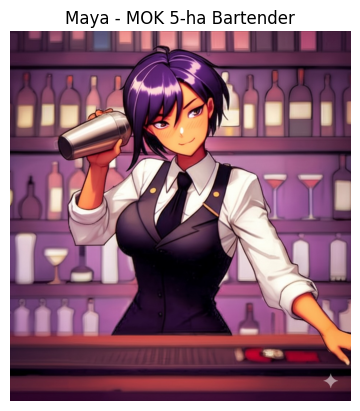

Avatar saved to bartender_avatar.jpg


In [19]:
# Default avatar URL - fixed source for consistent experience
default_avatar_url = "https://github.com/gen-ai-capstone-project-bartender-agent/MOK-5-ha/blob/main/assets/bartender_avatar_ai_studio.jpeg?raw=true"

# Download avatar
try:
    response = requests.get(default_avatar_url)
    if response.status_code == 200:
        avatar_bytes = response.content
        avatar_image = Image.open(io.BytesIO(avatar_bytes))
        print("Using default avatar image")
    else:
        print(f"Failed to download default avatar. Status code: {response.status_code}")
        # Create a blank avatar as fallback
        avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))
except Exception as e:
    print(f"Error using default avatar: {e}")
    # Create a blank avatar as fallback
    avatar_image = Image.new('RGB', (300, 300), color = (73, 109, 137))

# Display the avatar
plt.imshow(avatar_image)
plt.axis('off')
plt.title("Maya - MOK 5-ha Bartender")
plt.show()

# Save avatar for use in Gradio
avatar_path = "bartender_avatar.jpg"
avatar_image.save(avatar_path)
print(f"Avatar saved to {avatar_path}")

## The Interface Handler: Connecting Maya to the User Interface

The **handle_gradio_input()** function serves as the critical bridge between Gradio's web interface and Maya's AI functionality. This connector function:

1. **Processes User Input**: Receives text input from the Gradio UI and passes it to the core **process_order** function
2. **Maintains Conversation State**: Manages and transfers session history and order state between the UI and the backend logic
3. **Integrates Voice Output**: Automatically calls the text-to-speech functionality for each of Maya's responses
4. **Handles UI Updates**: Returns multiple values to update different UI components:
    - Clears the input field (by returning empty string)
    - Updates the chat history display
    - Updates the order tracking state
    - Provides audio data for playback in the UI
5. **Logs Interactions**: Maintains detailed logs of the user-bartender interaction for debugging

This function encapsulates the complete input/output cycle of the user interface, ensuring Maya's text responses and voice outputs are properly synchronized. It's the final integration point that brings together all of Maya's capabilities (order processing, RAG-enhanced conversation, voice synthesis) into a cohesive user experience.

Without this handler, Maya's sophisticated backend would remain disconnected from the user-facing Gradio interface.

In [20]:
def handle_gradio_input(
    user_input: str,
    session_history_state: List[Dict[str, str]],
    session_order_state: List[Dict[str, float]]
) -> Tuple[str, List[Dict[str, str]], List[Dict[str, str]], List[Dict[str, float]], Any]:
    """
    Gradio callback: Takes input/state, calls logic & TTS, returns updates.
    """
    logger.info(f"Gradio input: '{user_input}'")
    logger.debug(f"Received session history state (len {len(session_history_state)}): {session_history_state}")
    logger.debug(f"Received session order state (len {len(session_order_state)}): {session_order_state}")

    # Call text processing logic first
    response_text, updated_history, updated_history_for_gradio, updated_order, _ = process_order(
        user_input,
        session_history_state,
        session_order_state
    )

    # --- Get Voice Audio ---
    audio_data = None 
    # Check if there is a non-empty response text to synthesize
    if response_text and response_text.strip():
         audio_data = get_voice_audio(response_text) 
         if audio_data is None:
             logger.warning("Failed to get audio data from get_voice_audio.")
             # Optional: Add indication to user? E.g., append "[Audio failed]" to response_text
    else:
        logger.info("No response text generated, skipping TTS.")
    # --- End Get Voice Audio ---

    # Return updates including audio data (which might be None)
    return "", updated_history, updated_history, updated_order, audio_data

In [21]:
def clear_chat_state() -> Tuple[List, List, List, None]:
    """Clears UI/session state including audio."""
    logger.info("Clear button clicked - Resetting session state.")
    # Return empty lists for Chatbot/history/order, and None for the audio component
    return [], [], [], None

# Launch the Gradio Interface

# The Bartender Interface: Maya's Visual Presentation

The **launch_bartender_interface()** function creates Maya's visual presence and interactive environment. This function:

1. Creates the Visual Experience:
    - Sets up the Ocean theme for a cohesive dark appearance
    - Displays the MOK 5-ha bar header with emojis (🍹👋)
    - Presents Maya's welcoming introduction message

2. Manages Application State:
    - Initializes conversation history storage
    - Maintains order tracking state between interactions

3. Structures the Visual Layout:
    - Creates a two-column design with Maya's avatar on the left
    - Positions the chat interface on the right
    - Ensures responsive scaling for different screen sizes

4. Integrates Multi-Modal Elements:
    - Displays Maya's avatar image
    - Shows text conversation history
    - Embeds audio playback for Maya's voice responses
    - Provides text input for customer messages

5. Sets Up Event Handlers:
    - Connects the text input to the handle_gradio_input function
    - Enables both Enter key and button click submission
    - Provides a conversation reset button

This function completes Maya's implementation by providing the visual interface that customers interact with. The combination of avatar imagery, text chat, and voice responses creates an immersive bartending experience that goes beyond simple text interaction.

In [ ]:
def launch_bartender_interface():
    ui_theme = gr.themes.Ocean()
    # Create the interface
    with gr.Blocks(theme=ui_theme) as demo:
        gr.Markdown("# MOK 5-ha - Meet Maya the Bartender 🍹👋")
        gr.Markdown("Welcome to MOK 5-ha! I'm Maya, your virtual bartender. Ask me for a drink or check your order.")

        # --- Define Session State Variables ---
        history_state = gr.State([])
        order_state = gr.State([])

        # --- Restructured Main Row with 2 Columns (Equal Scaling) ---
        with gr.Row():

            # --- Column 1: Avatar Image ---
            # Scale is relative to other columns in the same row
            with gr.Column(scale=1, min_width=200): 
                gr.Image(
                    value=avatar_path,  
                    label="Bartender Avatar",
                    show_label=False,
                    interactive=False,
                    height=600, 
                    elem_classes=["avatar-image"]
                )

            # --- Column 2: Chat Interface ---
            with gr.Column(scale=1): 
                chatbot_display = gr.Chatbot(
                    [],
                    elem_id="chatbot",
                    label="Conversation",
                    height=489, 
                    type="messages"
                )
                agent_audio_output = gr.Audio(
                    label="Agent Voice",
                    autoplay=True,
                    streaming=False,
                    format="wav",
                    show_label=True,
                    interactive=False
                )
                msg_input = gr.Textbox(
                    label="Your Order / Message",
                    placeholder="What can I get for you? (e.g., 'I'd like a Margarita', 'Show my order')"
                )
                with gr.Row():
                    clear_btn = gr.Button("Clear Conversation")
                    submit_btn = gr.Button("Send", variant="primary")

        # --- Event Handlers (Remain the same) ---
        submit_inputs = [msg_input, history_state, order_state]
        submit_outputs = [msg_input, chatbot_display, history_state, order_state, agent_audio_output]
        msg_input.submit(handle_gradio_input, submit_inputs, submit_outputs)
        submit_btn.click(handle_gradio_input, submit_inputs, submit_outputs)

        clear_outputs = [chatbot_display, history_state, order_state, agent_audio_output]
        clear_btn.click(clear_chat_state, None, clear_outputs)

    # Launch the interface
    demo.launch(debug=True, share=True)  

# Run the Bartending Agent 🍹👋

For the intended experience, I recommend using your computer's or mobile device's **built-in dictation feature** to interact with Maya. Either that, or use [Wispr AI](https://wispr.ai) as I have.

- **Windows**: Available via the **Speech Recognition** feature in **Settings**

- **macOS**: Available via the **Dictation** feature in **System Preferences**

- **Google Chrome**: Available via microphone icon in the address bar

- **iOS**: Available via microphone key on the virtual keyboard

- **Android**: Available via the **Voice Typing** feature in **Settings** 
    - or **Google Keyboard** via microphone icon on keyboard


Follow the **public URL** that will appear after launching the cell below, as some functionality breaks within the code cell. Should look something like this:
* Running on public URL: https://bb30e51844a537e953.gradio.live

In [ ]:
# Launches the interface when this cell is executed
launch_bartender_interface()

Using Gradio's Ocean theme with dark mode for better readability


2025-04-20 13:55:41,725 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
2025-04-20 13:55:41,797 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-04-20 13:55:41,838 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


2025-04-20 13:55:42,145 - httpx - INFO - HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://bb30e51844a537e953.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2025-04-20 13:55:43,062 - httpx - INFO - HTTP Request: HEAD https://bb30e51844a537e953.gradio.live "HTTP/1.1 200 OK"


2025-04-20 13:56:09,767 - __main__ - INFO - Gradio input: 'Hi Maya!'
2025-04-20 13:56:09,776 - __main__ - INFO - Processing user input for session: Hi Maya!
2025-04-20 13:56:10,879 - __main__ - INFO - Enhancing response with RAG for casual conversation


Using Gemini model: gemini-2.5-flash-preview-04-17


2025-04-20 13:56:13,027 - __main__ - INFO - Original response: Hey there! Welcome to MOK 5-ha. Great to see you. What can I get started for you tonight?
2025-04-20 13:56:13,028 - __main__ - INFO - RAG-enhanced response: Well hello there! Yes, you've found Maya, reporting for duty behind the bar.
2025-04-20 13:56:13,029 - __main__ - INFO - Final agent response: Well hello there! Yes, you've found Maya, reporting for duty behind the bar.
2025-04-20 13:56:13,031 - __main__ - INFO - Requesting TTS from Cartesia (Voice ID: 6f84f4b8-58a2-430c-8c79-688dad597532) for: 'Well hello there! Yes, you've found Maya, reportin...'
2025-04-20 13:56:13,356 - httpx - INFO - HTTP Request: POST https://api.cartesia.ai/tts/bytes "HTTP/1.1 200 OK"
2025-04-20 13:56:14,704 - __main__ - INFO - Received 326170 bytes of WAV audio data from Cartesia.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bb30e51844a537e953.gradio.live


# Limitations

**Technical**

- **Limited Menu Parsing**: The menu parsing logic uses simple regex which may not handle complex menu formatting changes.

- **Concurrent User Handling**: The global state variables (**current_process_order_state**, **conversation_state**, etc.) aren't designed for multiple concurrent users, making this implementation suitable only for single-user interactions.

- **Fixed RAG Knowledge Base**: The small set of pre-defined documents for small talk limits Maya's conversational variety over extended interactions.

- **Token Limits**: There's a 2048 token limit on responses, which might truncate very detailed explanations.

- **Symbol Pronunciation**: Maya will still pronounce symbols (e.g. *, =, etc.)

**Functional**

- **Menu Modifications**: Users can't modify the menu (add specials, change prices) without code changes.

- **Order Editing**: While orders can be cleared completely, there's no built-in way to remove specific items from an order.

- **Time Awareness**: Maya doesn't track real time, so references to time of day or "happy hour" aren't connected to actual time.

- **No Memory Between Sessions**: Order history and conversation state are lost when the application restarts.

- **Limited Context Window**: Maya may lose track of earlier parts of long conversations due to the LLM's context window limitations.

- **Payment Processing**: No real way for Maya to actually process payments.

**UI**

- **Mobile Responsiveness**: The interface might not scale well on very small screens.
- **Audio Playback**: If browser settings block autoplay, the voice responses might not work without user intervention.
- **No Speech Input**: While Maya can speak, she can't listen - the interface only accepts text input.
- **Single-Language Support**: Maya is currently English-only, without multilingual capabilities.

These limitations are all manageable for a prototype bartender agent, and the core functionality of order taking, small talk, and philosophical conversation should work well within these constraints.